# Ovrlpy applied to vizgen receptor data map



#### Imports:

In [24]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Parameter definition:

In [25]:
import os
# from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# from sklearn.neighbors import NearestNeighbors
import anndata
import time

perf = time.perf_counter()
perf_ = perf

print(time.perf_counter()-perf)


3.766641020774841e-05


In [26]:
n_slice = 2

coordinate_path = f'/dh-projects/ag-ishaque/raw_data/vizgen-merfish/vz-receptor-showcase/Slice{n_slice}/Replicate1/detected_transcripts_S{n_slice}R1.csv'
# analysis/tiesmeys/data/vizgen-merfish/vz-receptor-showcase/Slice1/Replicate1/detected_transcripts_S1R1.csv'

scale=1 # scaling factor for images/coordinats. We want to end up with cell diameter ~30px (cellpose default)
# model_type='cyto2' # cellpose model name. ['dapi','cyto','cyto2']

In [27]:

# {0:'xenium_mouse_brain',1:'merfish_mouse_brain',2:'merfish_liver'}
dataset =0

file_root = '/dh-projects/ag-ishaque/analysis/tiesmeys/spot-data-z-axis-incoherence/src'


           global_x      global_y      global_z
count  4.874067e+07  4.874067e+07  4.874067e+07
mean   4.974135e+03  3.696136e+03  2.847259e+00
std    2.237596e+03  1.731014e+03  1.945633e+00
min    5.302726e+01 -7.666222e+01  0.000000e+00
25%    3.236294e+03  2.256036e+03  1.000000e+00
50%    4.957519e+03  3.637856e+03  3.000000e+00
75%    6.799679e+03  5.120410e+03  4.000000e+00
max    9.692914e+03  7.453246e+03  6.000000e+00
n_transcripts: 48574461, panel_size: 483


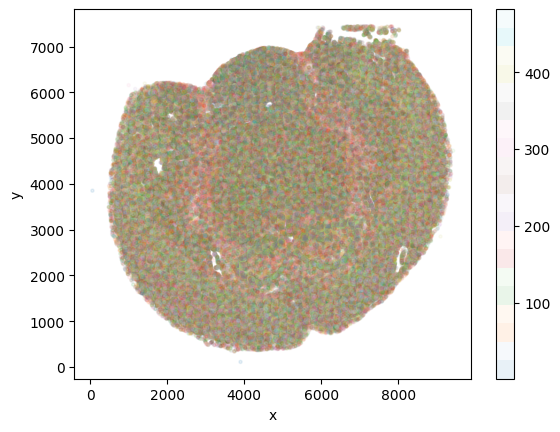

In [28]:
# Load coordinate_path data frame, read only the columns
# global_x, global_y, global_z, fov	gene:

import time

df = pd.read_csv(coordinate_path, sep=',', usecols=[2,3,4,8], header=0)[::1]

print(df.describe())


df.columns=['x','y','z','gene']
df = df[~df.gene.str.contains('Blank')]
# df.x-=df.x.min()
# df.y-=df.y.min()
# df.x/=um_per_pixel/scale
# df.y/=um_per_pixel/scale
# df.z/=um_per_pixel/scale

# df.gene.replace({'Acte1':'Gm498'})

df.gene = df.gene.astype('category')
gene_counts = df.gene.value_counts()
genes = list(gene_counts.index)

df[::200].plot.scatter(x='x',y='y',s=5,c=df[::200].gene.cat.codes,cmap='tab20',alpha=0.1)

print(f"n_transcripts: {len(df)}, panel_size: {len(genes)}")

In [29]:
signatures_ = pd.read_csv('/dh-projects/ag-ishaque/raw_data/Xenium-benchmark/scRNAseq/trimmed_means.csv',index_col=0)

signatures_ = signatures_.T.groupby(lambda x: x.split('_')[1].split(' ')[0].split('-')[0]).apply(lambda x: x.mean(0)).T

signatures = pd.DataFrame(index=genes,columns=signatures_.columns)
signatures = signatures.fillna(0.0)

for gene in genes:
    if gene in signatures_.index:
        signatures.loc[gene] = signatures_.loc[gene]

del signatures_ 
signatures.columns=signatures.columns.str.replace('/','-')


/tmp/ipykernel_730293/2048503760.py:6: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  signatures = signatures.fillna(0.0)


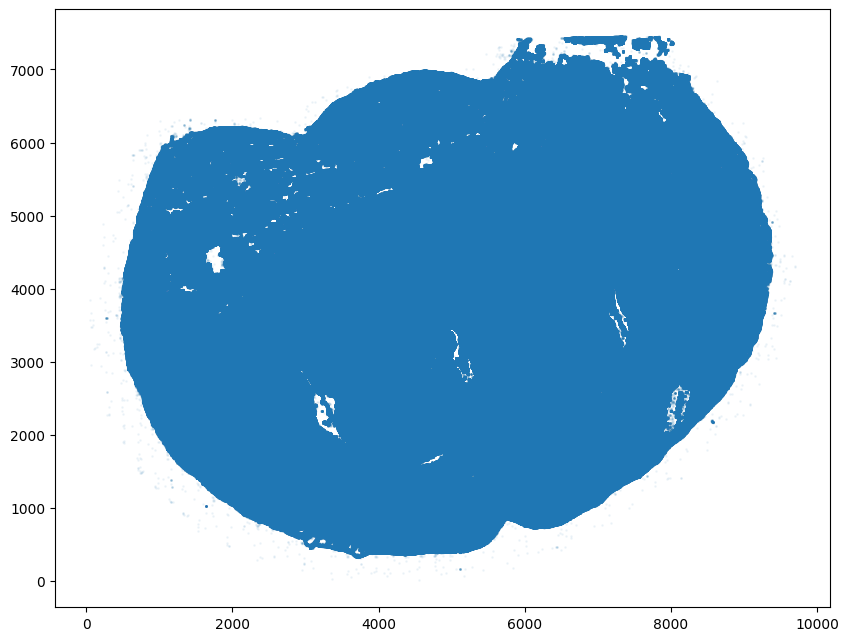

In [30]:
#
plt.figure(figsize=(10,10))


x_lims = [0,10000]
y_lims = [0,10000]

df_mask = (df.x>x_lims[0]) & (df.x<x_lims[1]) & (df.y>y_lims[0]) & (df.y<y_lims[1])

df = df[df_mask].copy()

mins = df[['x','y']].min()

# df.x-=df.x.min()
# df.y-=df.y.min()

plt.scatter(df.x,df.y,s=1,alpha=0.05)
plt.gca().set_aspect('equal') 
df.gene = df.gene.astype('str').astype('category')
gene_counts = df.gene.value_counts()
genes = gene_counts.index

# Adhere to project's global naming convention:
coordinate_df = df.copy()
del df


In [31]:
# import ovrlpy 

# signal_integrity, signal_strength,visualizer = ovrlpy.run(coordinate_df, cell_diameter=10, n_expected_celltypes=30)

# visualizer.plot_fit()

# visualizer.save("./publication/vizgen-receptor/vizgen-receptor.vis")

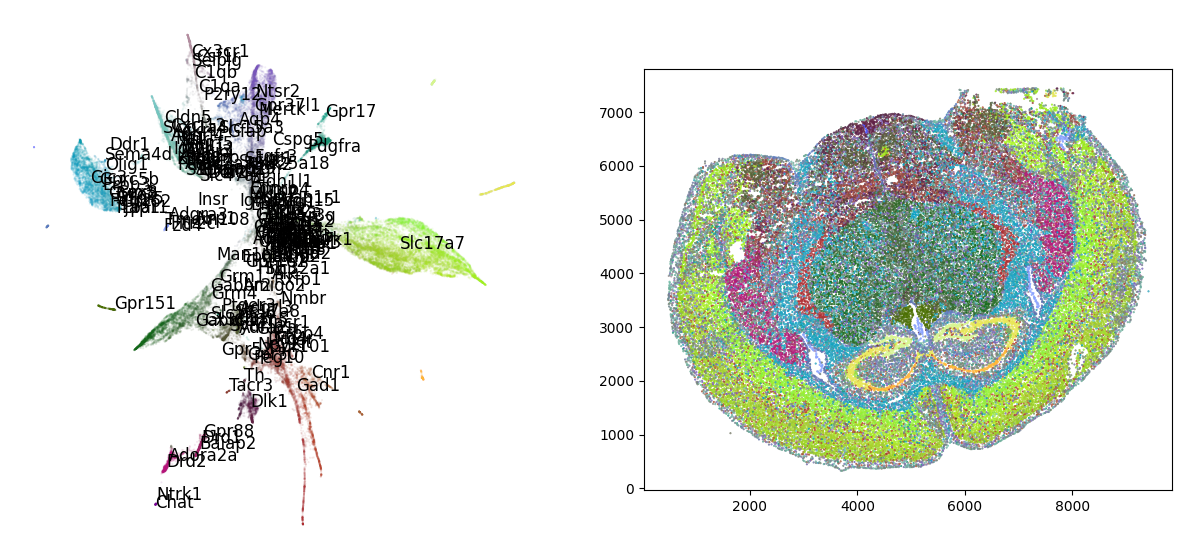

In [32]:
import ovrlpy

ovrlpy.pre_process_coordinates(coordinate_df)

visualizer = ovrlpy.load_visualizer("./publication/vizgen-receptor/vizgen-receptor.vis")
signal_integrity, signal_strength = visualizer.integrity_map, visualizer.signal_map


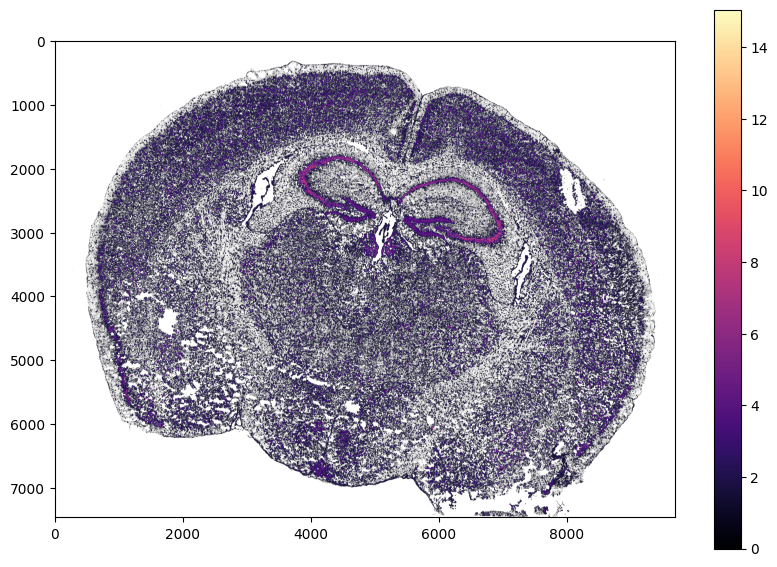

In [33]:
fig, ax = plt.subplots(1,1,figsize=(10,7))

plt.imshow(signal_strength, cmap='magma', alpha=(signal_strength.clip(0,1)))

plt.colorbar()

plt.savefig("./publication/vizgen-receptor/figures/signal_strength.svg",dpi=600)

/tmp/ipykernel_730293/3613141597.py:9: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  signatures = signatures.fillna(0.0)


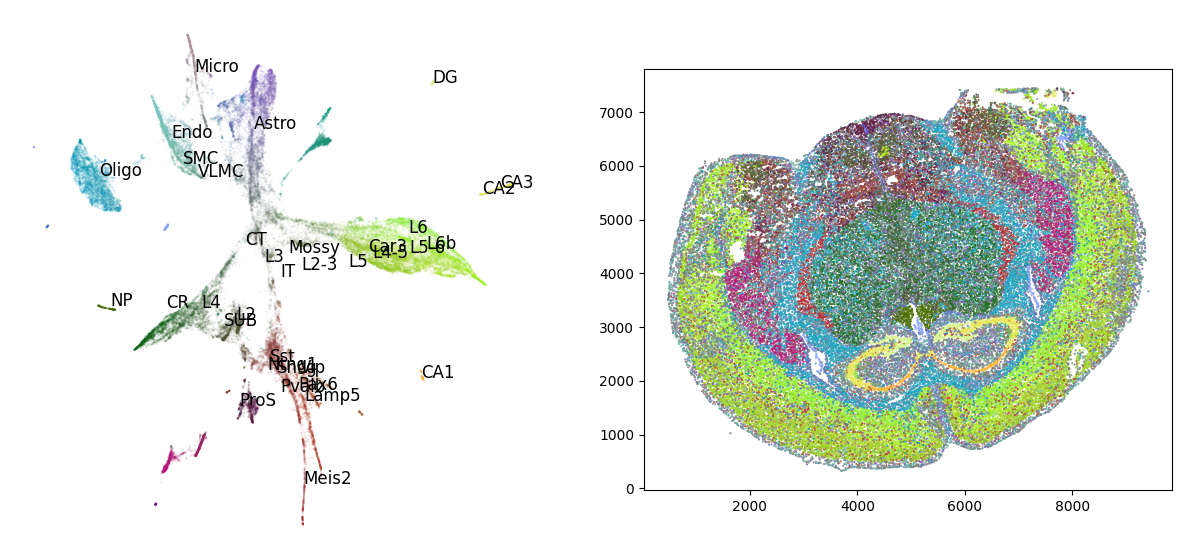

In [39]:
import numpy as np
import matplotlib.pyplot as plt

signatures_ = pd.read_csv('/dh-projects/ag-ishaque/raw_data/Xenium-benchmark/scRNAseq/trimmed_means.csv',index_col=0)

signatures_ = signatures_.T.groupby(lambda x: x.split('_')[1].split(' ')[0].split('-')[0]).apply(lambda x: x.mean(0)).T

signatures = pd.DataFrame(index=visualizer.genes,columns=signatures_.columns)
signatures = signatures.fillna(0.0)

for gene in visualizer.genes:
    if gene in signatures_.index:
        signatures.loc[gene] = signatures_.loc[gene]

del signatures_ 

signatures.columns=signatures.columns.str.replace('/','-')

visualizer.fit_signatures(signatures)

visualizer.plot_fit()

plt.savefig("./publication/vizgen-receptor/figures/receptor-fit",dpi=600)

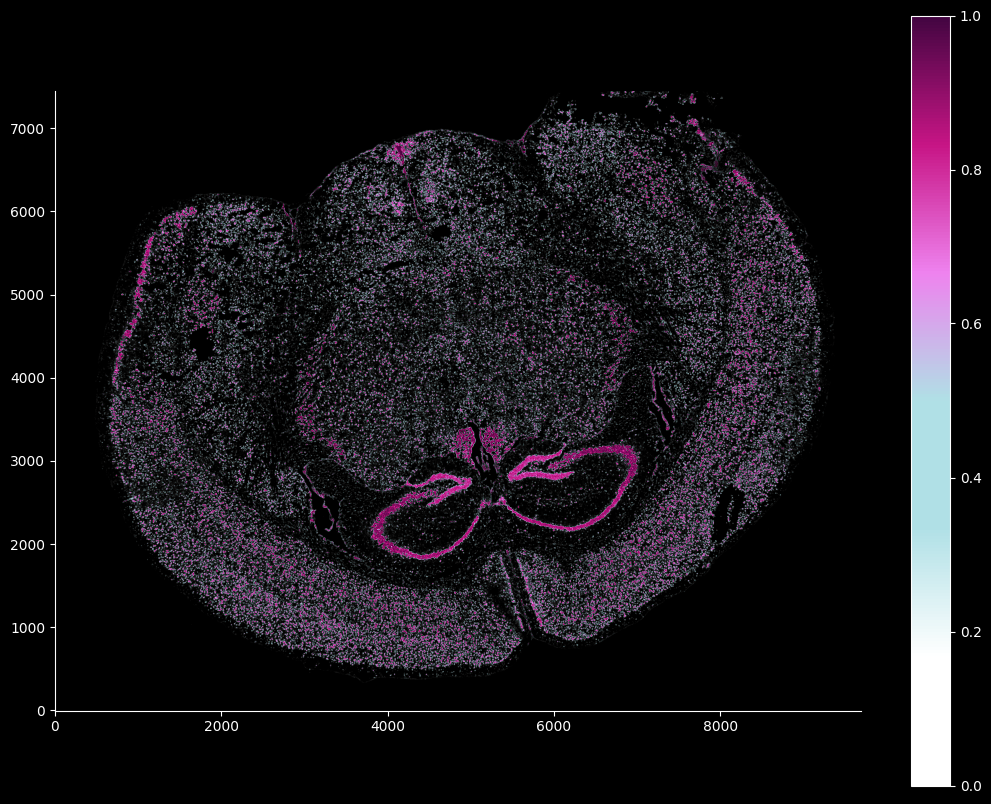

In [41]:
fig, ax = ovrlpy.plot_signal_integrity(
    signal_integrity, signal_strength, signal_threshold=3, plot_hist=False
)

plt.savefig('./publication/vizgen-receptor/figures/receptor_integrity.svg',dpi=600)

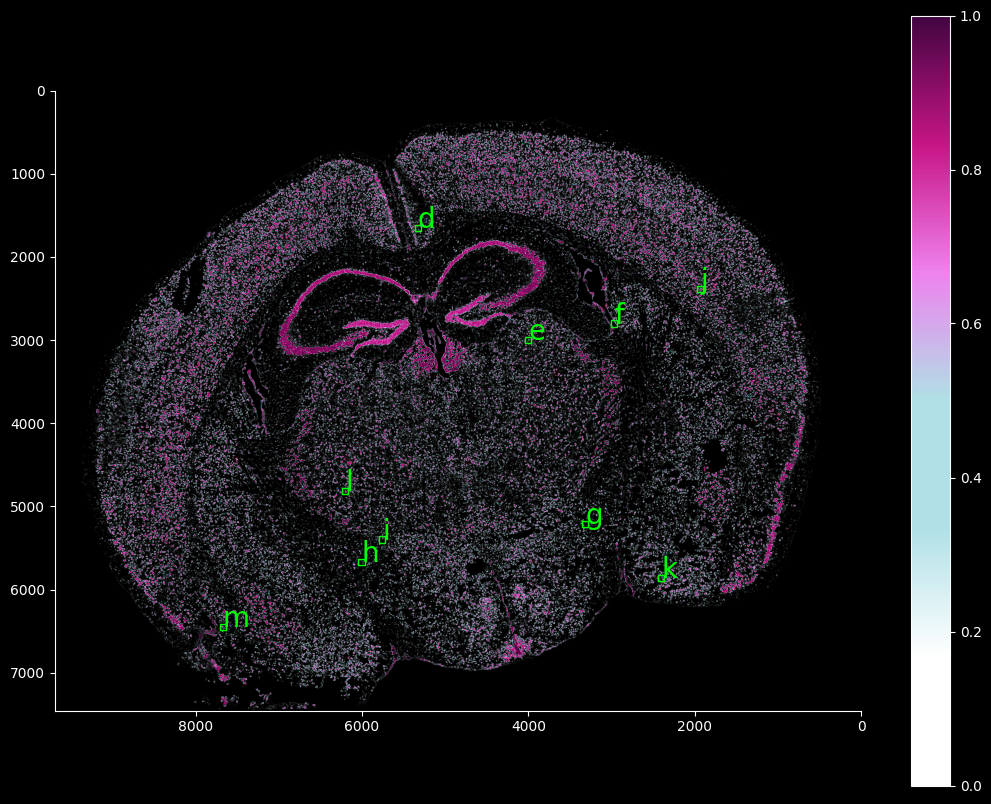

In [60]:
# doublet_df = ovrlpy.detect_doublets(
#     signal_integrity, signal_strength, minimum_signal_strength=3, integrity_sigma=2
# )

fig, ax = ovrlpy.plot_signal_integrity(
    signal_integrity, signal_strength, signal_threshold=3, plot_hist=False
)

alphabet = 'abcdefghijklmnopqrstuvwxyz'

for i in range(10):
    
    x,y = doublet_df.loc[i,['x','y']]
    ax[0].text(
        x,
        y,
        f"{alphabet[i+3]}",
        fontsize=20,
        color='lime',
        # transform=ax.transAxes,
    )
    
    plt.scatter(x,y,marker='s',s=20,edgecolors='lime', facecolors='None', linewidths=1)

ax[0].invert_yaxis()
ax[0].invert_xaxis()
plt.savefig('./publication/vizgen-receptor/figures/receptor_integrity.svg',dpi=600)

In [38]:
window_size = 50

for doublet_case in range(10):
    x, y = doublet_df.loc[doublet_case, ["x", "y"]]

    ovrlpy.plot_region_of_interest(
        x,
        y,
        coordinate_df,
        visualizer,
        signal_integrity,
        signal_strength,
        window_size=window_size,
    )
    
    plt.savefig(f'./publication/vizgen-receptor/figures/doublet-case-visualizations/receptor_doublet_case_{doublet_case+1}.svg',dpi=600)
    
    plt.close()

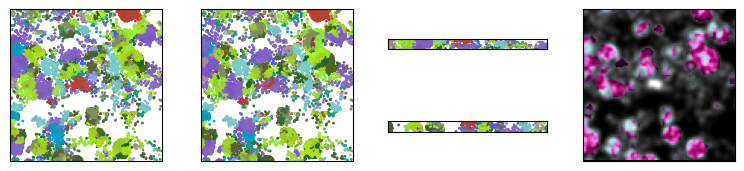

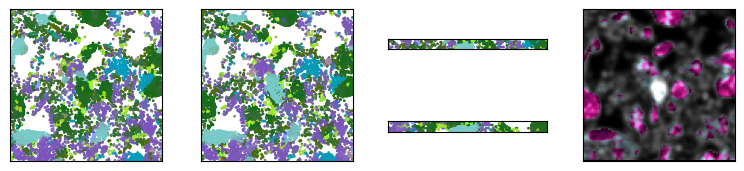

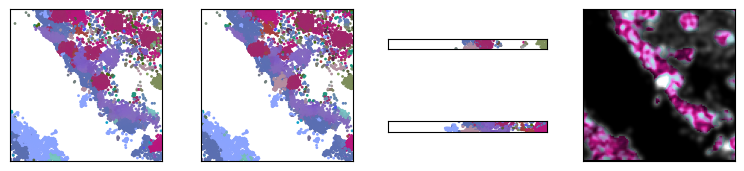

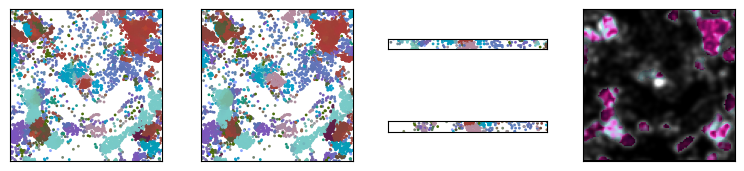

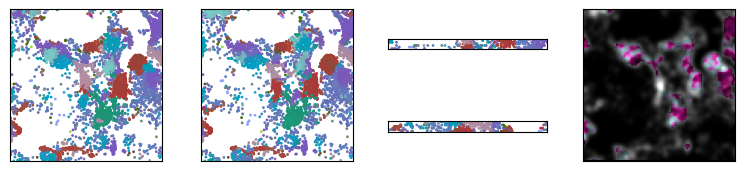

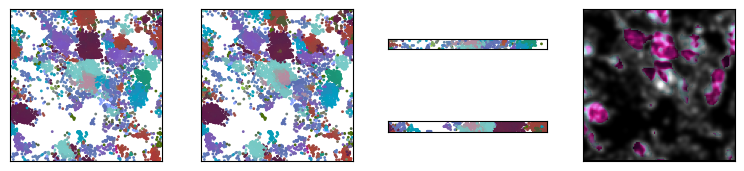

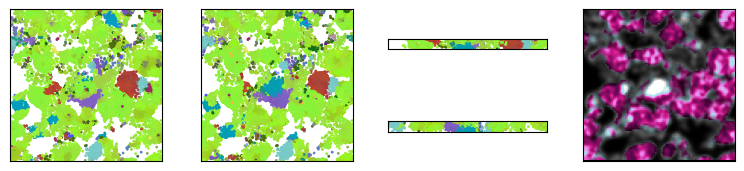

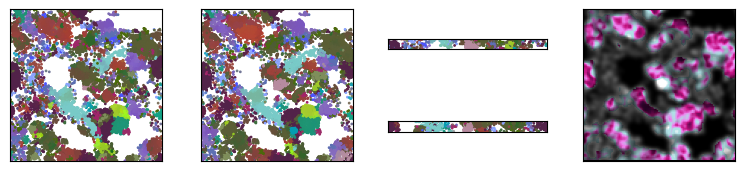

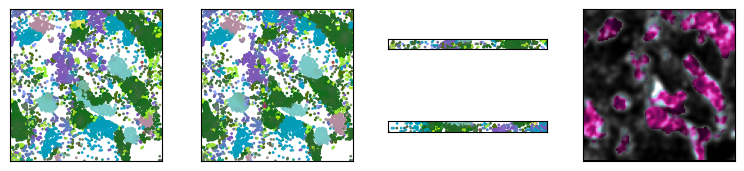

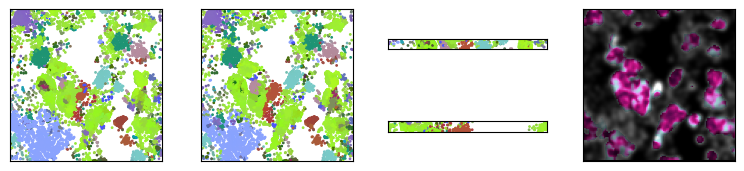

In [61]:
from matplotlib.gridspec import GridSpec
from ovrlpy._ovrlp import _BIH_CMAP as cmap

subsample_rgbs = []
centimeter = 1/2.54

window_size = 50

def finalize_axes(ax,x,y,window_size):
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    if x is not np.nan:
        ax.set_xlim(x-window_size,x+window_size)
    if y is not np.nan:
        ax.set_ylim(y-window_size,y+window_size)
        
    if y is not np.nan:
        ax.invert_yaxis()
    ax.invert_xaxis()

for i in range(10):
    
    x,y = doublet_df.loc[i,['x','y']]
    
    subsample = visualizer.subsample_df(x,y,coordinate_df=coordinate_df,window_size=window_size)
    
    subsample_embedding, subsample_rgb = visualizer.transform_transcripts(subsample)
    
    subsample_z_order = subsample.z.argsort()
    
    plt.figure(figsize=(24*centimeter,5*centimeter))
    
    gs = plt.GridSpec(2, 4,)
    
    ax_top = plt.subplot(gs[:, 0])
    plt.scatter(x=subsample.x.iloc[subsample_z_order],y=subsample.y.iloc[subsample_z_order],c=subsample_rgb[subsample_z_order],s=1,rasterized=True)
    finalize_axes(ax_top,x,y,window_size)

    ax_bottom = plt.subplot(gs[:, 1])
    plt.scatter(x=subsample.x.iloc[subsample_z_order[::-1]],y=subsample.y.iloc[subsample_z_order[::-1]],c=subsample_rgb[subsample_z_order[::-1]],s=1,rasterized=True)
    finalize_axes(ax_bottom,x,y,window_size)
    
    ax_horizontal_x = plt.subplot(gs[0, 2])
    mask_h = subsample.y.between(y-5,y+5)
    plt.scatter(x=subsample.x[mask_h],y=subsample.z[mask_h],c=subsample_rgb[mask_h],s=1,rasterized=True)
    finalize_axes(ax_horizontal_x,x,np.nan,window_size)
    
    ax_horizontal_y = plt.subplot(gs[1, 2])
    mask_v = subsample.x.between(x-5,x+5)
    plt.scatter(x=subsample.y[mask_v],y=subsample.z[mask_v],c=subsample_rgb[mask_v],s=1,rasterized=True)
    finalize_axes(ax_horizontal_y,y,np.nan,window_size)
    
    ax_integrity = plt.subplot(gs[:, 3],facecolor='black')
    plt.imshow(signal_integrity[int(y)-window_size:int(y)+window_size,int(x)-window_size:int(x)+window_size,],
               alpha=(signal_strength[int(y)-window_size:int(y)+window_size,int(x)-window_size:int(x)+window_size,]/3).clip(0,1).astype(float),cmap=cmap,vmin=0,vmax=1)
    rect = plt.Rectangle((x-35,y-35),70,70,fill=None,edgecolor='lime',lw=2)
    ax_integrity.add_artist(rect)    
    finalize_axes(ax_integrity,window_size,window_size,window_size)

    plt.savefig(f'./publication/vizgen-receptor/figures/doublet-case-visualizations/receptor_doublet_case_{i+1}.svg',dpi=600)